# Analysis of Custom-KinFragLib 

## Aim of this notebook

Plotting results of Custom-KinFragLib for the paper. 

## Table of contents

1. Library sizes

    1.1 Pre-filter KinFragLib vs CustomKinFragLib library size

    1.2 Number of fragments after each filtering step 

2. Fragment space 

    2.1 t-SNE plot
    
    2.2 Clustering coverage 

    2.3 Average Tanimoto similarity 

## Imports and preprocessing

In [1]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, MACCSkeys
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np 
from collections import Counter
import math

from kinfraglib import filters, utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / ".." / ".."/ "data"

In [5]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")
fragment_library = filters.prefilters.pre_filters(fragment_library_original)


In [6]:
fragment_library_original.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

In [7]:
fragment_library_custom = utils.read_fragment_library(PATH_DATA / "fragment_library_custom_filtered")
fragment_library_custom.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1'])

### 1. Library sizes
#### 1.1 Pre-filtered vs custom library size

In [8]:
SUBPOCKET_COLORS = {
    "AP": "purple",
    "FP": "forestgreen",
    "SE": "c",
    "GA": "tab:orange",
    "B1": "tab:blue",
    "B2": "darkslateblue",
}

def plot_n_fragments_per_subpocket(
    n_fragments_per_subpocket, n_fragments_per_subpocket_custom
):
    """
    Plot number of fragments and deduplicated fragments per subpocket.
    """
    plt.figure(figsize=(8, 8))
    ax1 = plt.bar(
        SUBPOCKET_COLORS.keys(),
        n_fragments_per_subpocket,
        fill=False,
        edgecolor=SUBPOCKET_COLORS.values(), log=1
    )
    ax2 = plt.bar(
        SUBPOCKET_COLORS.keys(),
        n_fragments_per_subpocket_custom,
        color=SUBPOCKET_COLORS.values(), log=1
    )
    plt.legend(["KinFragLib\nfragments", "CustomKinFragLib\nfragments"], fontsize=17)
    plt.ylabel("# Fragments", fontsize=17)
    plt.xlabel("Subpocket", fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    # Add absolute numbers of custom-kinfraglib fragments on top 
    bars = ax1.patches

    for bar, label in zip(bars, n_fragments_per_subpocket_custom):

        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            label,
            ha="center",
            va="bottom",
            fontsize=17,
            color="black",
        )
    plt.savefig(f"figures/n_fragments_per_subpocket.pdf", dpi=300, bbox_inches="tight")

In case the number of subpockets of the original KinFragLib and CustomKinFragLib differs, we need to add empty subpockets for the figures to add this to the statistics: 

In [9]:
if len(fragment_library.keys()) != len(fragment_library_custom.keys()): 
    difference = list(set(fragment_library_original.keys()) - set(fragment_library_custom.keys()))
    print(f"The pockets: {difference} are empty in CustomKinFragLib.")
    for pocket in difference: 
        fragment_library_custom[pocket] = pd.DataFrame()

The pockets: ['B2'] are empty in CustomKinFragLib.


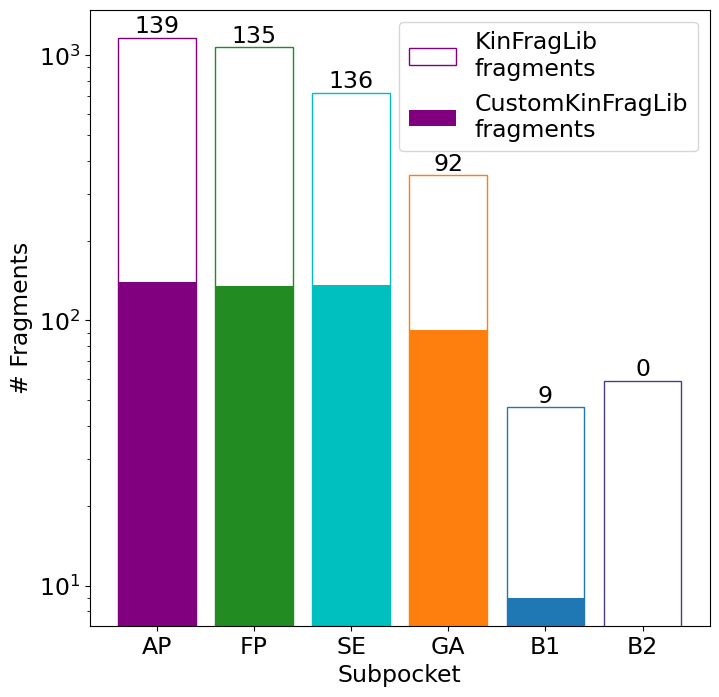

In [10]:
n_fragments_per_subpocket_prefiltered = [len(fragments.drop_duplicates('smiles')) for _, fragments in fragment_library.items()]
n_fragments_per_subpocket_custom = [len(fragments) for _, fragments in fragment_library_custom.items()]
plot_n_fragments_per_subpocket(n_fragments_per_subpocket_prefiltered, n_fragments_per_subpocket_custom)

#### 1.2 Number of fragments after each filtering step 

In [11]:
PATH_DATA_CUSTOM = PATH_DATA / "fragment_library_custom_filtered"
filter_results = pd.read_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv", na_values = [""])

In [12]:
def percent_frags_development(filter_res):
    """
    Calculate the percentage of fragments removed in each custom filter step 

    ----------
    filter_res : dataframe
        Contains the calculated values and the boolean for each filtering step if a fragment was
        accepted or not.

    Returns
    ---------
    dataframe
        with the percentage of fragments per subpocket for each filtering step

    """
    # get the column names
    frag_keys = filter_res.keys()
    frag_keys.to_list()
    total_counts = filter_res.subpocket.value_counts()
    total_counts['All'] = total_counts.sum()
    # keep only the boolean column names (we do not need the computed values here)
    bool_keys = [x for x in frag_keys if "bool" in x and "retro" not in x]
    # create a dataframe to store the number of fragments left after each filtering step
    update_results = pd.DataFrame(0, index=SUBPOCKET_COLORS.keys(), columns=[k[5:] for k in bool_keys])
    # go through all boolean columns and count the number of fragments passing
    for bool_key in bool_keys:
        filter_res_temp = filter_res.loc[filter_res[bool_key] == 0]
        update_results[bool_key[5:]] = filter_res_temp.reset_index().groupby("subpocket", sort=False).size() 
    update_results.loc[-1] = update_results.sum() 
    # add numbers for all subpockets 
    update_results = update_results.rename(index={-1 : "All"})

    # get percentage 
    update_results = update_results.div(total_counts, axis="rows") * 100
    # reorder rows 
    update_results = update_results.reindex(index=total_counts.index)
    # create a bar plot showing the numbers of fragments passing
    ax = update_results.plot.bar(width=0.9)
    fig = ax.get_figure()

    fig.set_figheight(7)
    fig.set_figwidth(13)

    ax.set_xlabel("Subpocket")
    ax.set_ylabel("% of fragments removed")
    ax.set_title("Percentage of fragments removed in each filtering step")
    # increase fontsizes 
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    plt.ylim(0, 80)
    plt.xticks(rotation=0)
    plt.legend(loc="upper right", prop={'size':15})
    plt.savefig(f"figures/n_fragments_filter_step.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    # return dataframe with number of fragments after each filtering step.
    return update_results.iloc[0:-1]

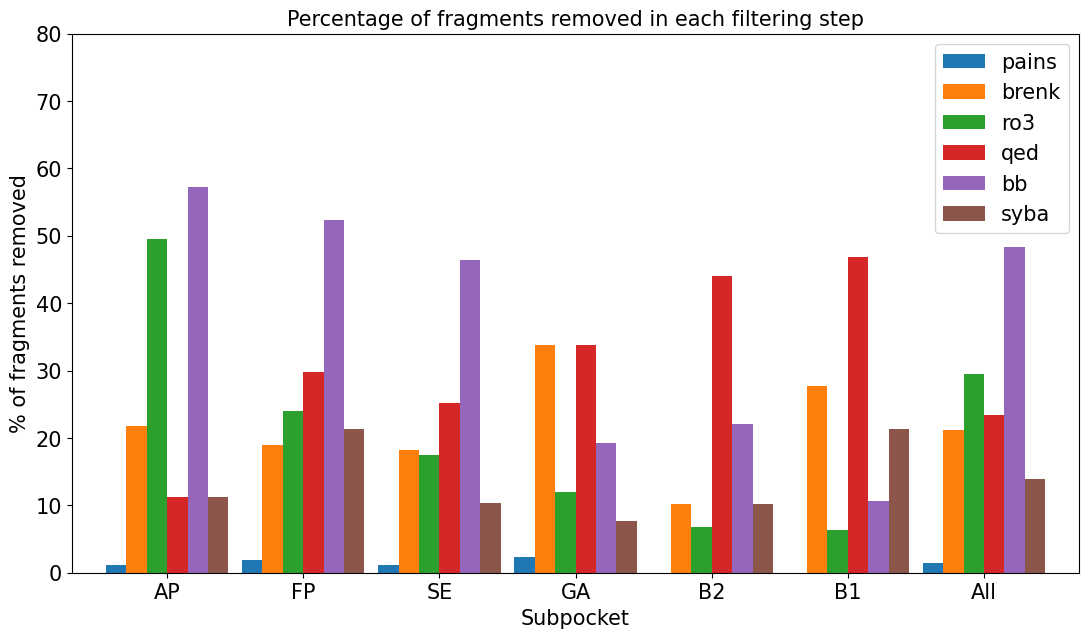

In [13]:
update_results = percent_frags_development(filter_results)

In [14]:
print("Percentage of fragments removed by each filtering criteria:")
update_results.round(3)

Percentage of fragments removed by each filtering criteria:


,pains,brenk,ro3,qed,bb,syba
AP,1.117,21.735,49.485,11.254,57.302,11.254
FP,1.961,18.954,23.996,29.785,52.381,21.289
SE,1.110,18.169,17.476,25.243,46.463,10.402
GA,2.273,33.807,11.932,33.807,19.318,7.670
B2,NaN,10.169,6.780,44.068,22.034,10.169
B1,NaN,27.660,6.383,46.809,10.638,21.277


In [15]:
def num_frags_total(filter_res):
    """
    Count the number of fragments passing each custom filter step

    ----------
    filter_res : dataframe
        Contains the calculated values and the boolean for each filtering step if a fragment was
        accepted or not.

    Returns
    ---------
    dataframe
        with the number of fragments per subpocket for each filtering step

    """
    # get the column names
    frag_keys = filter_res.keys()
    frag_keys.to_list()
    # keep only the boolean column names (we do not need the computed values here)
    bool_keys = [x for x in frag_keys if "bool" in x and "retro" not in x]
    # create a dataframe to store the number of fragments left after each filtering step
    update_results = pd.DataFrame()
    # add number of fragments for the pre-filtered subset we are starting with
    update_results["Pre-filtered"] = filter_res.reset_index().groupby(
        "subpocket", sort=False
    ).size()
    # go through all boolean columns and count the number of fragments passing
    for bool_key in bool_keys:
        filter_res = filter_res.loc[filter_res[bool_key] == 1]
    
    update_results["All filters"] = filter_res.reset_index().groupby("subpocket", sort=False).size()
    filter_res = filter_res.loc[filter_res['bool_retro'] == 1]
    update_results["Filters + retro"] = filter_res.reset_index().groupby("subpocket", sort=False).size()
    # create a bar plot showing the numbers of fragments passing
    ax = update_results.plot.bar(width=0.9)
    fig = ax.get_figure()

    fig.set_figheight(7)
    fig.set_figwidth(13)

    ax.set_xlabel("Subpocket")
    ax.set_ylabel("Number of fragments")
    ax.set_title("Total number of fragments remaining")
    # increase fontsizes 
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    plt.legend(prop={'size':15})
    plt.xticks(rotation=0)
    plt.savefig(f"figures/n_fragments_filter_total.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    # return dataframe with number of fragments after each filtering step.
    return update_results

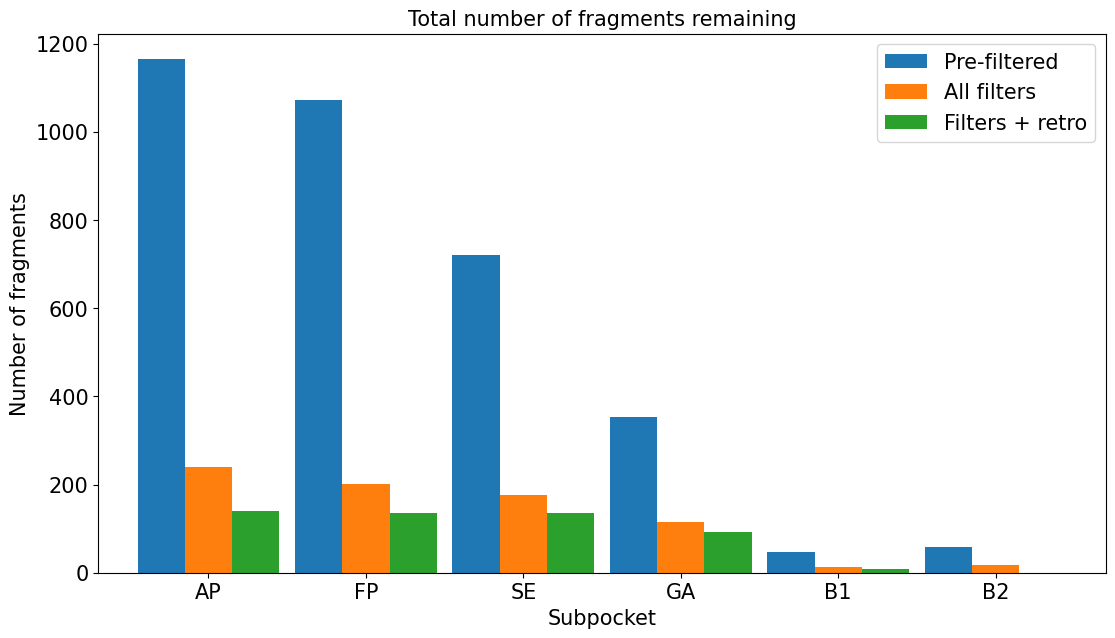

,Pre-filtered,All filters,Filters + retro
subpocket,,,
AP,1164,239,139.0
FP,1071,202,135.0
SE,721,176,136.0
GA,352,114,92.0
B1,47,13,9.0
B2,59,18,NaN


In [16]:
num_frags_total(filter_results)

#### 1.3 KinFragLib update

**Download data**

Here we analyze the number of fragments in the old version of KinFragLib compared to the updated version, which contains a newer version of KLIFS data (from Nov. 2023). 
To run this part of the code, we need to download the old KinFragLib version from zenodo. Please follow the instructions given in `../data/fragment_library_old/README.md`.

In [17]:
fragment_library_old = utils.read_fragment_library(PATH_DATA / "fragment_library_old")
fragment_library_new = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [18]:
SUBPOCKET_COLORS_X = {
    "AP": "purple",
    "FP": "forestgreen",
    "SE": "c",
    "GA": "tab:orange",
    "B1": "tab:blue",
    "B2": "darkslateblue",
    "X": "grey",
}

def plot_n_fragments_kinfraglib(
    n_fragments_per_subpocket_new, n_fragments_per_subpocket_old
):
    """
    Plot number of fragments and deduplicated fragments per subpocket.
    """
    plt.figure(figsize=(8, 8))
    ax1 = plt.bar(
        SUBPOCKET_COLORS_X.keys(),
        n_fragments_per_subpocket_new,
        fill=False,
        edgecolor=SUBPOCKET_COLORS_X.values(),
    )
    ax2 = plt.bar(
        SUBPOCKET_COLORS_X.keys(),
        n_fragments_per_subpocket_old,
        color=SUBPOCKET_COLORS_X.values(),
    )
    plt.legend(["Updated KinFragLib\nfragments", "Previous KinFragLib\nfragments"], fontsize=17)
    plt.ylabel("# Fragments", fontsize=17)
    plt.xlabel("Subpocket", fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    plt.savefig(f"figures/old_vs_new_kinfraglib.pdf", dpi=300, bbox_inches="tight")

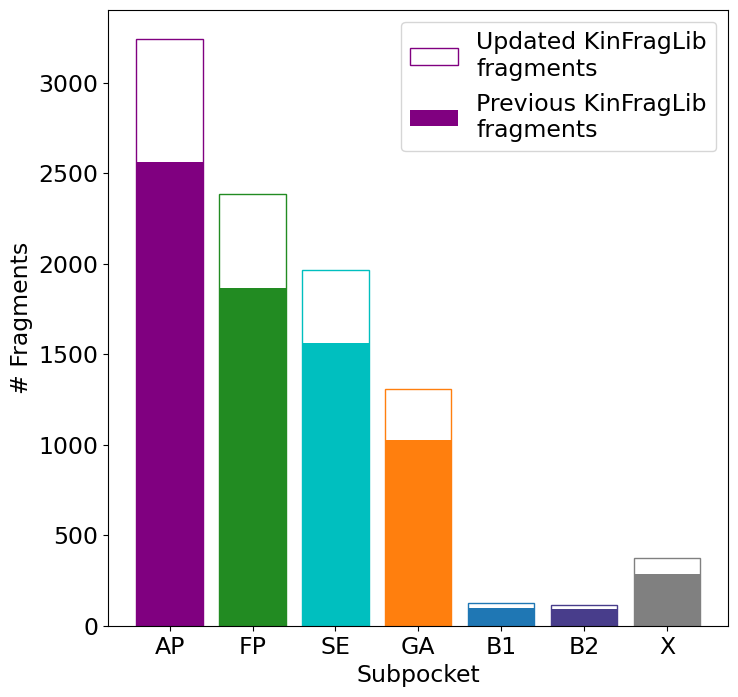

In [19]:
n_fragments_per_subpocket_new = [len(fragments) for _, fragments in fragment_library_new.items()]
n_fragments_per_subpocket_old = [len(fragments) for _, fragments in fragment_library_old.items()]
plot_n_fragments_kinfraglib(n_fragments_per_subpocket_new, n_fragments_per_subpocket_old)

### 2. Fragment space 

#### 2.1 t-SNE plot
t-SNE plot of pre-filtered KinFragLib with fragments colored in based on each filter respectively. 

In [20]:
def calc_tsne(fragment_library): 
    """
    Creates t-SNE embeddings of pre-filtered KinFragLib library.

    ----------
    fragment_library : dict
        fragment library organized in subpockets

    Returns
    ---------
    dataframe
        with the t-SNE embedding 
    """
    # calculate MACCS fingerprints for t-sne 
    fragment_library["ROMol"] = fragment_library.smiles.apply(Chem.MolFromSmiles)
    fragment_library["maccs"] = fragment_library.ROMol.apply(MACCSkeys.GenMACCSKeys)
    pca = PCA(n_components=50)
    crds = pca.fit_transform(list(fragment_library["maccs"]))
    crds_embedded = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=0).fit_transform(crds)
    tsne_df = pd.DataFrame(crds_embedded, columns=["X", "Y"])

    return tsne_df

In [21]:
def create_tsne_plots(fragment_library_concat, bool_filter, tsne_df):
    """
    Creates t-SNE plots comparing pre-filtered and custom filtered fragment library.

    ----------
    fragment_library : dict
        fragment library organized in subpockets containing boolean column 
         defining if the fragments are part of the subset (specified in bool_filter)
    bool_filter: str
        filter that should be used for coloring the fragments (should be a column in fragment_library_concat)
    tsne_df: dataframe
        contains the t-sne embedding of pre-filtered KinFragLib
    """

    tsne_df[bool_filter] = fragment_library_concat[bool_filter]

    sns.scatterplot(
        data=tsne_df.query(bool_filter + " == 0"),
        x="X",
        y="Y",
        color='lightcoral',
        alpha=0.5,
        label="excluded"
    ).set_title("pre-filtered vs. custom KinfragLib fragments")
    sns.scatterplot(
        data=tsne_df.query(bool_filter + " == 1"),
        x="X",
        y="Y",
        color='green',
        alpha=0.5,
        label="included"
    )

    plt.legend()
    plt.savefig(f"figures/tsne_" + bool_filter + ".pdf", dpi=300, bbox_inches="tight")
    plt.show()


In [22]:
# create bool_custom column indicating whether the fragment is in CustomKinFragLib or not
frag_keys = filter_results.keys()
frag_keys.to_list()
bool_keys = [x for x in frag_keys if "bool" in x]

# go through all boolean columns (filters)
bool_custom = pd.Series([True]*len(filter_results))
for bool_key in bool_keys:
    bool_custom = bool_custom & filter_results[bool_key] == 1
filter_results["bool_custom"] = bool_custom


In [23]:
# calculate t-SNE coordinates once only 
tsne_df = calc_tsne(filter_results)

#### CustomKinFragLib t-SNE

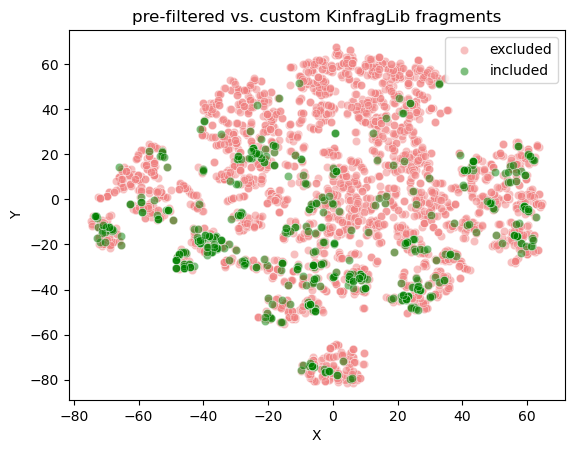

In [24]:
create_tsne_plots(filter_results, "bool_custom", tsne_df)

#### KinFragLib subspaces

These plots are the same as in notebook 2.2. However, they include the full fragment space, while in notebook 2.2, we sampled a subset to shorten the computational runtime of the t-SNE. 

We compare the following fragment library sets:

- Pre-filtered fragment library vs. reduced fragment library
- Pre-filtered fragment library vs. custom filtered fragment library
- Pre-filtered fragment library vs. reduced fragment library vs. custom filtered fragment library

In [25]:
fragment_library_reduced = utils.read_fragment_library(PATH_DATA / "fragment_library_reduced")
fragment_library = filters.analysis.frag_in_subset(fragment_library, fragment_library_reduced, colname = "bool_reduced")
fragment_library = filters.analysis.frag_in_subset(fragment_library, fragment_library_custom, colname = "bool_custom")

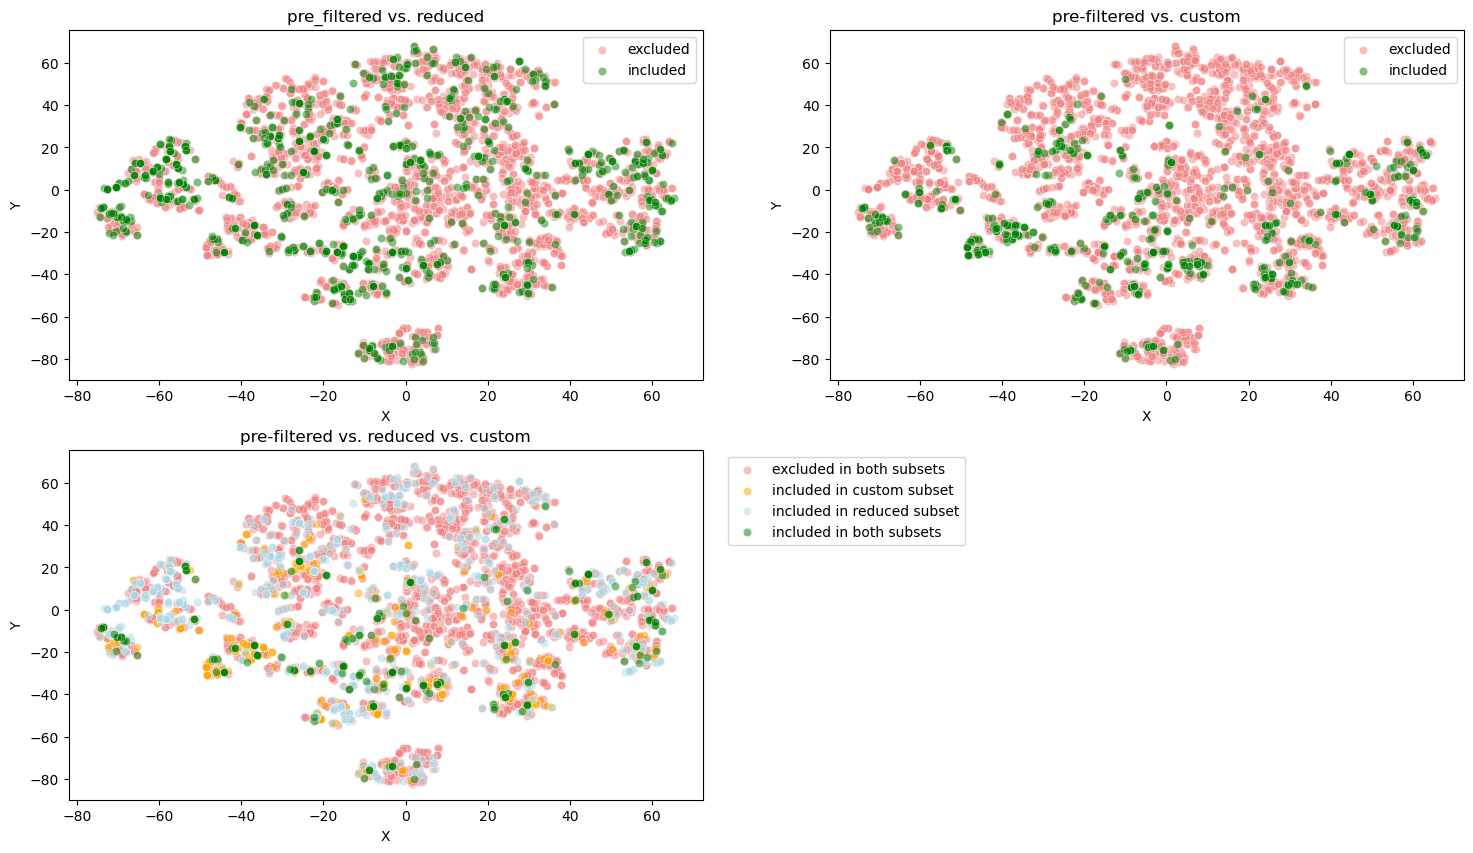

3414 Pre-filtered fragments.
        Number of fragments excluded in both datasets: 2193
        Number of fragments included in the custom dataset and excluded in the reduced dataset: 328
        Number of fragments included in the reduced dataset and excluded in the custom dataset: 672
        Number of fragments in both datasets: 221 


In [26]:
crds_embedded = filters.plots.create_tsne_embeddings(fragment_library, 50)
tsne_df = filters.plots.create_tsne_plots(crds_embedded, fragment_library)

#### Ro3 t-SNE

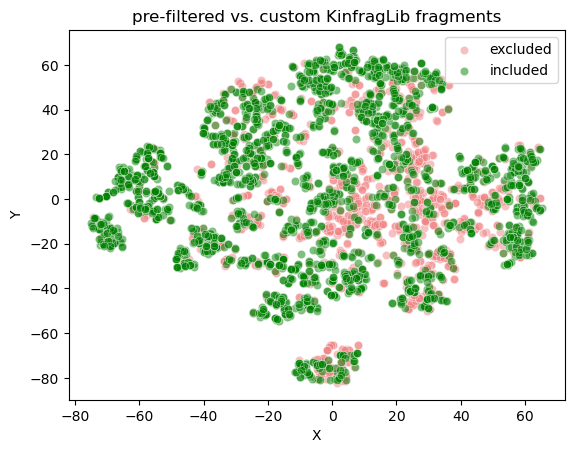

In [27]:
create_tsne_plots(filter_results, "bool_ro3", tsne_df)

#### Building block t-SNE

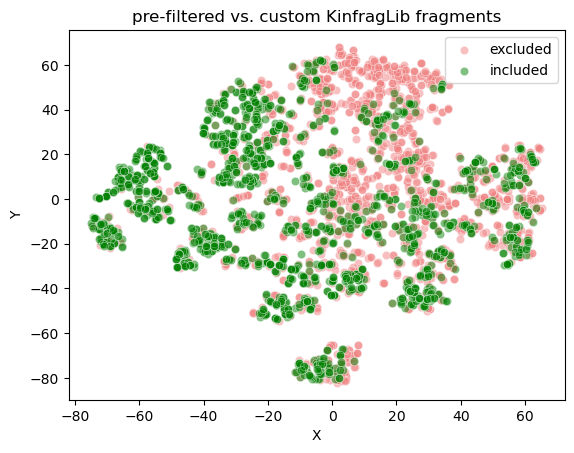

In [28]:
create_tsne_plots(filter_results, "bool_bb", tsne_df)

#### Brenk t-SNE

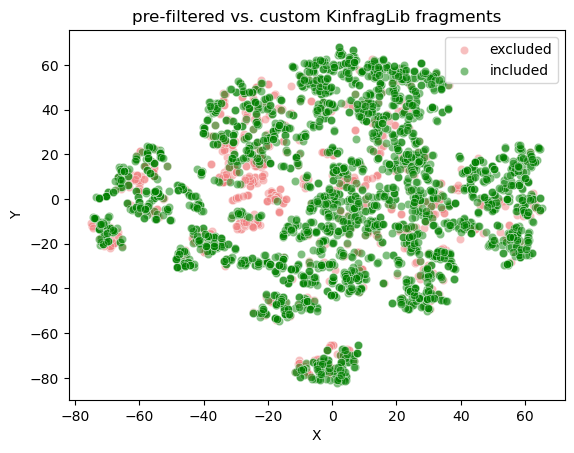

In [29]:
create_tsne_plots(filter_results, "bool_brenk", tsne_df)

#### QED t-SNE

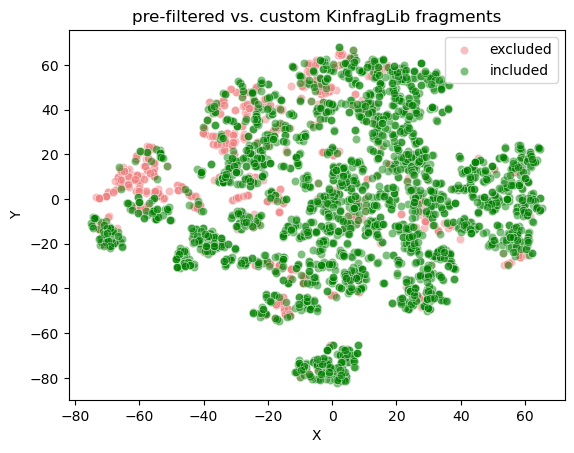

In [30]:
create_tsne_plots(filter_results, "bool_qed", tsne_df)

#### SYBA t-SNE

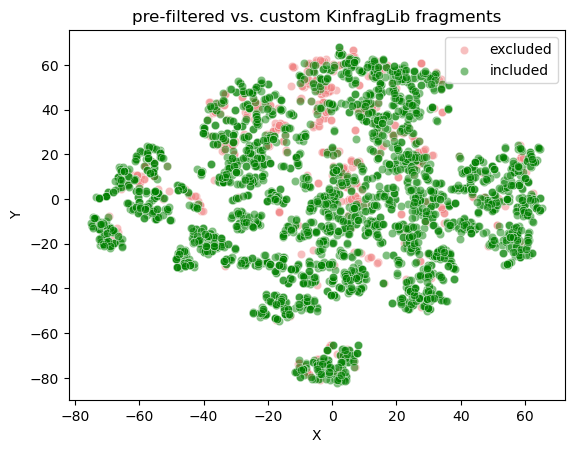

In [31]:
create_tsne_plots(filter_results, "bool_syba", tsne_df)

#### PAINS t-SNE

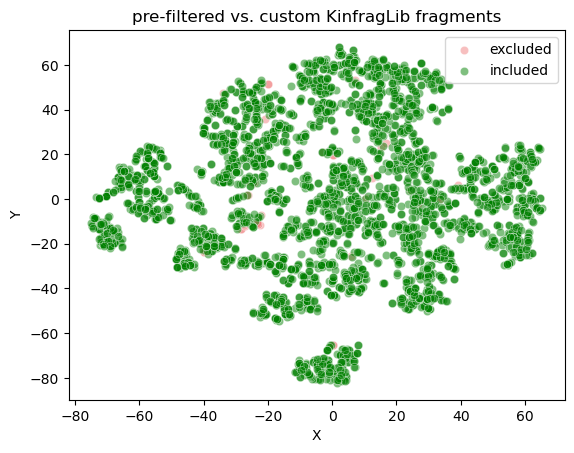

In [32]:
create_tsne_plots(filter_results, "bool_pains", tsne_df)

#### 2.2 Clustering
[Not used in the paper]

In [33]:
fragment_library_reduced = utils.read_fragment_library(PATH_DATA / "fragment_library_reduced")
fragment_library_custom = utils.read_fragment_library(PATH_DATA / "fragment_library_custom_filtered")


In [34]:
smiles = pd.concat(fragment_library).smiles.tolist()
smiles_custom = pd.concat(fragment_library_custom).smiles.tolist()

In [35]:
clusters = utils.cluster_molecules(pd.concat(fragment_library).ROMol, cutoff=0.6)

Number of molecules: 3414
Threshold:  0.6
Number of clusters:  527
# Clusters with only 1 molecule:  234
# Clusters with more than 5 molecules:  124
# Clusters with more than 25 molecules:  25
# Clusters with more than 100 molecules:  4


In [36]:
cluster_indexes = []
for smi in smiles_custom: 
    ind = smiles.index(smi)
    cluster_id = clusters[clusters.molecule_id == ind].cluster_id
    cluster_indexes.append(int(cluster_id))


In [37]:
print(f"{len(set(cluster_indexes))} clusters out of {max(clusters.cluster_id)} clusters in total ({round(len(set(cluster_indexes))/max(clusters.cluster_id), 4) * 100} %) are covered in customKinFragLib")

100 clusters out of 527 clusters in total (18.98 %) are covered in customKinFragLib


In [38]:
covered_comps = sum(clusters.cluster_id.isin(cluster_indexes))
print(f"{covered_comps} out of {len(smiles)} compounds ({round(covered_comps/len(smiles) * 100, 2)}%) have a common cluster representative in customKinFragLib")

2049 out of 3414 compounds (60.02%) have a common cluster representative in customKinFragLib


In [39]:
cluster_counts = Counter(clusters.cluster_id)
custom_cluster_counts = [cluster_counts[c] for c in list(set(cluster_indexes))]
custom_counts = [0, 0, 0, 0, 0]
custom_counts[0] = sum([1 for count in custom_cluster_counts if count == 1])
custom_counts[1] = sum([1 for count in custom_cluster_counts if count > 1])
custom_counts[2] = sum([1 for count in custom_cluster_counts if count > 5])
custom_counts[3] = sum([1 for count in custom_cluster_counts if count > 25])
custom_counts[4] = sum([1 for count in custom_cluster_counts if count > 100])


In [40]:
fragment_counts = [0, 0, 0, 0, 0]
fragment_counts[0] = sum([1 for count in list(cluster_counts.values()) if count == 1])
fragment_counts[1] = sum([1 for count in list(cluster_counts.values()) if count > 1])
fragment_counts[2] = sum([1 for count in list(cluster_counts.values()) if count > 5])
fragment_counts[3] = sum([1 for count in list(cluster_counts.values()) if count > 25])
fragment_counts[4] = sum([1 for count in list(cluster_counts.values()) if count > 100])
#c_200 = sum([1 for count in list(cluster_counts.values()) if count > 100])

In [41]:
columns = ['1', '>1', '>5', '>25', '>100']
fraction = [c/f for (c, f) in zip(custom_counts, fragment_counts)]
df = pd.DataFrame(zip(columns, custom_counts, fragment_counts, fraction), columns=['Count', 'CustomKinFragLib', 'Pre-filtered fragment library', 'Coverage'])

In [42]:
print("Coverage per cluster size:")
df.round({'Coverage': 2})

Coverage per cluster size:


,Count,CustomKinFragLib,Pre-filtered fragment library,Coverage
0,1,8,234,0.03
1,>1,92,293,0.31
2,>5,71,124,0.57
3,>25,21,25,0.84
4,>100,3,4,0.75


#### 2.3 Average Tanimoto similarity 

In [43]:
def calc_avg_tanimoto_distance(molecules: list) -> float: # maybe add this to utils (?)
    """
    Returns the mean tanimoto distance of a given list of molecules.

    Returns
    -------
    Mean tanimoto distance of given molecules

    Parameters
    -----------
    molecules: list
        List of molecules (rdkit.Mol)
    """
    # Generate fingerprints
    fps = utils._generate_fingerprints(molecules)

    # Calculate Tanimoto distance matrix
    distance_matrix = utils._get_tanimoto_distance_matrix(fps)

    return np.mean(distance_matrix), np.std(distance_matrix)

In [44]:
mols = pd.concat(fragment_library).ROMol.tolist()
mols_custom = pd.concat(fragment_library_custom).ROMol.tolist()


In [45]:
div, std = calc_avg_tanimoto_distance(mols)
div_custom, std_custom = calc_avg_tanimoto_distance(mols_custom)
print(f'Diversity of pre-filtered KinFragLib: {div:.3f}+-{std:.3f}')
print(f'Diversity of CustomKinFragLib: {div_custom:.3f}+-{std_custom:.3f}')

Diversity of pre-filtered KinFragLib: 0.907+-0.086
Diversity of CustomKinFragLib: 0.863+-0.118


##### 2.3.1 Average Tanimoto Similarity per Subpocket

In [46]:
print(f"Avg. diversity per subpocket:\n")
print(f"Subpocket\tPre-filtered KinFragLib\t\tCustomKinFragLib")
print(f"---------\t-----------------------\t\t----------------")
for subpocket in fragment_library:
    mols = fragment_library[subpocket].ROMol.tolist()
    div, std = calc_avg_tanimoto_distance(mols)
    try: 
        mols_custom = fragment_library_custom[subpocket].ROMol.tolist()
        div_custom, std_custom = calc_avg_tanimoto_distance(mols_custom)
        print(f"{subpocket}\t\t{div:.2f}+-{std:.2f}\t\t\t{div_custom:.2f}+-{std_custom:.2f}")
    except:
        # for empty subpockets, print Nan
        print(f"{subpocket}\t\t{div:.2f}+-{std:.2f}\t\t\t---")
        continue

Avg. diversity per subpocket:

Subpocket	Pre-filtered KinFragLib		CustomKinFragLib
---------	-----------------------		----------------
AP		0.86+-0.09			0.82+-0.12
FP		0.91+-0.09			0.88+-0.11
SE		0.90+-0.10			0.86+-0.13
GA		0.90+-0.11			0.84+-0.13
B1		0.91+-0.13			0.84+-0.16
B2		0.91+-0.11			---


#### 2.4 Standadized Shannon Entropy of Murcko Scaffolds 

In [47]:
# add murcko scaffolds to fragment library 
for subpocket in fragment_library.keys():
    PandasTools.AddMurckoToFrame(fragment_library[subpocket])
    try: 
        PandasTools.AddMurckoToFrame(fragment_library_custom[subpocket])
    except KeyError: 
        print(f"Subpocket {subpocket} not in CustomKinFragLib, skipping this.")

Subpocket B2 not in CustomKinFragLib, skipping this.


Some fragments do not contain any rings and hence have an empty murcko scafold. Since the number of these fragments is rather low, and we cannot make any assumption on them, we exclude them in the following entropy calculations. 

In [48]:
num_fragments = pd.concat(fragment_library).shape[0]
num_fragments_custom = pd.concat(fragment_library_custom).shape[0]

num_empty_scaffolds = sum((sum(fragments['Murcko_SMILES'] == "") for fragments in fragment_library.values()))
num_empty_scaffolds_custom = sum((sum(fragments['Murcko_SMILES'] == "") for fragments in fragment_library_custom.values()))

print(f"Total numer of pre-filtered KinFragLib fragments: {num_fragments}")
print(f"Number of pre-filtered KinFragLib fragments with empty scaffold: {num_empty_scaffolds} ({100 * num_empty_scaffolds/num_fragments:.1f}%)\n")

print(f"Total numer of CustomKinFragLib fragments: {num_fragments_custom}")
print(f"Number of CustomKinFragLib fragments with empty scaffold: {num_empty_scaffolds_custom} ({100 * num_empty_scaffolds_custom/num_fragments_custom:.1f}%)")

Total numer of pre-filtered KinFragLib fragments: 3414
Number of pre-filtered KinFragLib fragments with empty scaffold: 296 (8.7%)

Total numer of CustomKinFragLib fragments: 511
Number of CustomKinFragLib fragments with empty scaffold: 5 (1.0%)


In [49]:
def calc_sse(murcko_smiles: pd.Series) -> float:
    """
    Returns the scaled Shannon Entropy of a given list of Murcko scaffold.

    Returns
    -------
    Scaled Shannon Entropy of a given list of Murcko scaffold

    Parameters
    -----------
    molecules: Pandas.Series
        List of Murcko scaffolds as SMILES (str)
    """
    p = murcko_smiles.shape[0]

    unique_scaffolds = murcko_smiles.value_counts()

    se = - sum((scaffold_count/p) * math.log2(scaffold_count/p) for scaffold_count in unique_scaffolds)
    
    return se / math.log2(unique_scaffolds.shape[0])

In [50]:
murcko_smiles = pd.concat(fragment_library)[pd.concat(fragment_library)['Murcko_SMILES'] != ""]['Murcko_SMILES']
murcko_smiles_custom = pd.concat(fragment_library_custom)[pd.concat(fragment_library_custom)['Murcko_SMILES'] != ""]['Murcko_SMILES']

In [51]:
sse = calc_sse(murcko_smiles)
sse_custom = calc_sse(murcko_smiles_custom)
print(f'SSE of pre-filtered KinFragLib: {round(sse, 3)}')
print(f'SSE of CustomKinFragLib: {round(sse_custom, 3)}')

SSE of pre-filtered KinFragLib: 0.78
SSE of CustomKinFragLib: 0.697


In [52]:
print(f"SSE per subpocket:\n")
print(f"Subpocket\tPre-filtered KinFragLib\t\tCustomKinFragLib")
print(f"---------\t-----------------------\t\t----------------")
for subpocket in fragment_library:
    murcko_smiles = fragment_library[subpocket][fragment_library[subpocket]['Murcko_SMILES'] != ""]['Murcko_SMILES']
    try: 
        murcko_smiles_custom = fragment_library_custom[subpocket][fragment_library_custom[subpocket]['Murcko_SMILES'] != ""]['Murcko_SMILES']
        sse = calc_sse(murcko_smiles)
        sse_custom = calc_sse(murcko_smiles_custom)

        print(f"{subpocket}\t\t{sse:.3f}\t\t\t\t{sse_custom:.3f}")
    except KeyError: 
        # subpocket not in CustomKinFragLib 
        print(f"{subpocket}\t\t{sse:.3f}\t\t\t\t---")


SSE per subpocket:

Subpocket	Pre-filtered KinFragLib		CustomKinFragLib
---------	-----------------------		----------------
AP		0.878				0.885
FP		0.808				0.745
SE		0.806				0.694
GA		0.649				0.632
B1		0.675				0.887
B2		0.675				---


### 3. Overlaps of filters 

Here, we investigate if our filters are redundant, e.g. how many molecules are filtered out by two different filters. 

In [53]:
bool_filters = ["bool_pains", "bool_brenk", "bool_ro3", "bool_qed", "bool_bb", "bool_syba"]
for i in range(len(bool_filters)): 
    for j in range(i+1, len(bool_filters)): 
        # overlap between the two filters
        filter_1 = bool_filters[i]
        filter_2 = bool_filters[j]
        if filter_1 != filter_2: 
            sum_columns = filter_results[filter_1] + filter_results[filter_2]
            overlap = sum_columns.value_counts()[0]
            print(f"Overlap of {filter_1} and {filter_2}: {overlap}")

Overlap of bool_pains and bool_brenk: 44
Overlap of bool_pains and bool_ro3: 30
Overlap of bool_pains and bool_qed: 17
Overlap of bool_pains and bool_bb: 30
Overlap of bool_pains and bool_syba: 3
Overlap of bool_brenk and bool_ro3: 265
Overlap of bool_brenk and bool_qed: 233
Overlap of bool_brenk and bool_bb: 341
Overlap of bool_brenk and bool_syba: 176
Overlap of bool_ro3 and bool_qed: 149
Overlap of bool_ro3 and bool_bb: 732
Overlap of bool_ro3 and bool_syba: 122
Overlap of bool_qed and bool_bb: 240
Overlap of bool_qed and bool_syba: 223
Overlap of bool_bb and bool_syba: 295


### 4. Enamine building blocks vs KinFragLib similarity 

In [54]:
DATA_ENAMINE = HERE / "../../data/filters/Enamine/most_similar_enamine_fragment.sdf"

In [55]:
enamine_mols = []
similarities_enamine = []
for mol in Chem.SDMolSupplier(str(DATA_ENAMINE)): 
    if "enamine" in mol.GetProp("_Name"): 
        enamine_mols.append(mol)
        similarities_enamine.append(float(mol.GetProp("Similarity")))

Text(0, 0.5, 'Number of molecules')

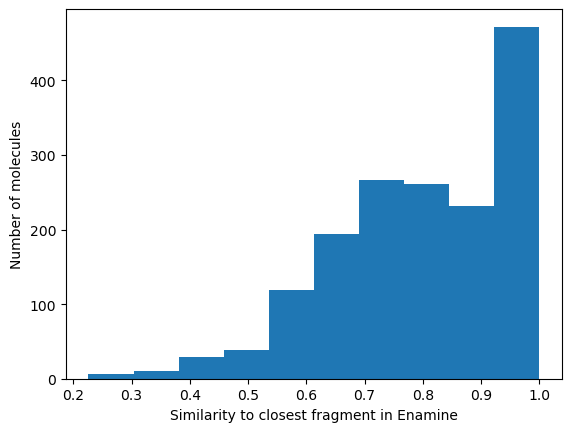

In [56]:
plt.hist(similarities_enamine)
plt.xlabel("Similarity to closest fragment in Enamine")
plt.ylabel("Number of molecules")

In [57]:
exact_matches = []
for mol in enamine_mols: 
    if float(mol.GetProp("Similarity")) == 1.0: 
        exact_matches.append(mol)
print(f"{len(exact_matches)} KinFragLib fragments have a similarity of 1.0 to an Enamine building block")

344 KinFragLib fragments have a similarity of 1.0 to an Enamine building block
